## Fitting our plankton ODE to time series in Stan



First we load the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

Load the data from our the `data` folder where we saved our synthetic data

We separate the `tobs` and `obs` variables so to pass them separately to Stan

In [2]:
dat = np.loadtxt('../data/data_npz_synthetic.csv', delimiter=',')

tobs = dat[:,0]
obs  = dat[:,[1,2,3]]

Below is the Stan code for our model
Note that there are several ways to pass Stan code to the Stan program.
Here we are using character strings to easily integrate with a standalone notebook.

Stan programs are structured as templated blocks. 
Different types of models will use different blocks.
We will use the `functions`, `data`, `parameters`, `transformed parameters`, and `model` blocks.
We explain each one in turn.

#### `functions` block
Here we define our ordinary differential equation function.
Our function will take the current time `t`, current state `x`, and the model parameter vector `theta` as inputs, and will return the rate of change for each state variable.

#### `data` block
We pass the data and all model inputs in the `data` block. 
In this case Stan needs:
1. The number of observations `nobs`. Note that a single observation is a single point in time where N, P, and/or Z may be observed.
2. The time points where those observations live `tobs`.
3. The number of variables for which there are observations `nobsvar`.
4. The indices of the observed variables: N=0, P=1, Z=2 
5. Matrix of observations `obs`. This matrix as `nobs` rows and three columns for the 3 state variables. Note that we are passing Stan all three variables, but only telling Stan to look at the variables indexed by `iobsvar`.

#### `parameter` block
We tell Stan which unknown parameters we seek to estimate via the `parameters` block.
We will estimate the intercept `beta0`, the slope `beta1` and the error standard devation `sigma`.
We give `sigma` a lower bound of a very small positive number to tell Stan not to try fitting with a standard deviation less than or equal to zero because it doesn't make mathemtical sense and Stan will get angry.

#### `model` block
The `model` block contains two components (despite it only being one block): the prior and likelihood.
This is where we tell Stan about the probability distributions being used in the problem.
You can tell the prior and likelihood apart in that the prior will not use the data, while the likelihood will. 
The likelihood will describe the distribution of the data *conditional on the parameters*.
Here we assign normal distributions with mean zero and standard deviation 100 to `beta0` and `beta1`.
We assign a normal distribution to the data with mean `beta0 + beta1*x` and standard deviation `sigma`.

In [3]:
stan_code = '''
functions {
   real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[]  x_i) { // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr          light amplitude
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = 1.0 + 0.5*(theta[6]*sin(pi()*((t-81.25)/182.5))-theta[6]); 
    real growth = theta[1]*n/(theta[2]+n) * light * p;
    real grazing = theta[3]*p*z;
    real ploss = theta[4]*p;
    real zloss = theta[5]*z*z;
    
    return {-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss};
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=0, P=1, Z=2)
    real<lower=0> obs[nobs,3]; // observed variable at measurement times
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0,upper=1> irr;
    real<lower=0> x0[3];            // initial conditions
    real<lower=0> sigma[nobsvar];   // obs error
}
transformed parameters {
    real x[nobs, 3];
    { 
        /* The curly braces here are creating a local variable scope.
        Variables declared inside the curly braces, like theta, cannot be used outside 
        the curly braces, they are also not included in the Stan output.
        Stan already outputs posterior samples for the model parameters, so additional 
        output for theta is not useful. Output for x is desired and x is also used in 
        the model block, so it needs to be declared outside the curly braces.
        */
        real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
        x = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                               rep_array(0.0, 0), rep_array(0, 0),
                               1e-5, 1e-4, 1e4);
    }
}
model {
    vmax       ~ normal(0.1, 0.1);
    nuthalfsat ~ uniform(0.0, 1.0);
    graz       ~ normal(0.01, 0.01);
    mort_p     ~ normal(0.01, 0.01);
    mort_z     ~ normal(0.01, 0.01);
    irr        ~ uniform(0.0, 1.0);
    x0[1:3]    ~ normal(0.1, 0.1);
    for (iobs in 1:nobs){
        obs[iobs,iobsvar] ~ normal(x[iobs,iobsvar], sigma);
    }
}
'''

In [4]:
# we can specify an optional model name
# setting obfuscate_model_name=False will prevent random characters 
# from being added to the model name 
model = pystan.StanModel(model_code=stan_code, model_name='NPZ', obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL NPZ NOW.


In [5]:
iobsvar = np.array([0,1])

In [6]:
# convert from Python's 0-based indexing to Stan's 1-based
data = {'nobs':len(tobs), 'tobs':tobs, 'nobsvar':len(iobsvar), 'iobsvar':iobsvar+1, 'obs':obs}

In [7]:
mcmc = model.sampling(data=data, iter=2000, chains=4)
print(mcmc)

Inference for Stan model: NPZ.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax         0.09  6.5e-4   0.01   0.07   0.08   0.09    0.1   0.12    409    1.0
nuthalfsat   0.43  7.1e-3   0.17   0.18    0.3    0.4   0.53   0.84    579    1.0
graz         0.02  1.1e-4 3.7e-3   0.01   0.02   0.02   0.02   0.02   1067    1.0
mort_p       0.02  1.5e-4 5.0e-3   0.01   0.02   0.02   0.02   0.03   1137    1.0
mort_z       0.02  1.7e-4 6.4e-3   0.01   0.02   0.02   0.03   0.04   1432    1.0
irr          0.89  2.8e-3   0.08   0.71   0.83    0.9   0.95    1.0    889    1.0
x0[1]        0.62  8.2e-4   0.03   0.56   0.61   0.63   0.64   0.67   1280    1.0
x0[2]        0.15  4.8e-4   0.01   0.12   0.14   0.14   0.15   0.18    887    1.0
x0[3]        0.26  1.3e-3   0.06   0.15   0.22   0.26   0.29   0.37   1708    1.0
sigma[1]     0.03  1.6e-4 7.0e-

Examining the `mcmc` object.

In [8]:
print('mcmc has the type:', type(mcmc))

print()
# the parameter names can be obtained via mcmc.flatnames
print('mcmc contains samples for:', ', '.join(mcmc.flatnames))

# the mcmc object can be accessed like a dictionary to obtain the Stan output / samples from 
# the posterior distribution

print()
print('posterior mean of vmax:', np.mean(mcmc['vmax']))

# we can use mcmc['x'] or mcmc['x[1,2]'] to index 

print()
for name in ('vmax', 'x', 'x[1,2]'):
    print(name, 'has shape', mcmc[name].shape)

# obtain 10th sample (index 9) of N at the second observation time
print()
if mcmc['x[1,2]'][9] == mcmc['x'][9,0,1]:
    print("mcmc['x[1,2]'][9] == mcmc['x'][9,0,1]")

mcmc has the type: <class 'stanfit4NPZ_3976694974413698235.StanFit4Model'>

mcmc contains samples for: vmax, nuthalfsat, graz, mort_p, mort_z, irr, x0[1], x0[2], x0[3], sigma[1], sigma[2], x[1,1], x[2,1], x[3,1], x[4,1], x[5,1], x[6,1], x[7,1], x[8,1], x[9,1], x[10,1], x[11,1], x[12,1], x[13,1], x[14,1], x[15,1], x[16,1], x[17,1], x[18,1], x[19,1], x[20,1], x[1,2], x[2,2], x[3,2], x[4,2], x[5,2], x[6,2], x[7,2], x[8,2], x[9,2], x[10,2], x[11,2], x[12,2], x[13,2], x[14,2], x[15,2], x[16,2], x[17,2], x[18,2], x[19,2], x[20,2], x[1,3], x[2,3], x[3,3], x[4,3], x[5,3], x[6,3], x[7,3], x[8,3], x[9,3], x[10,3], x[11,3], x[12,3], x[13,3], x[14,3], x[15,3], x[16,3], x[17,3], x[18,3], x[19,3], x[20,3]

posterior mean of vmax: 0.08961818031641945

vmax has shape (4000,)
x has shape (4000, 20, 3)
x[1,2] has shape (4000,)

mcmc['x[1,2]'][9] == mcmc['x'][9,0,1]


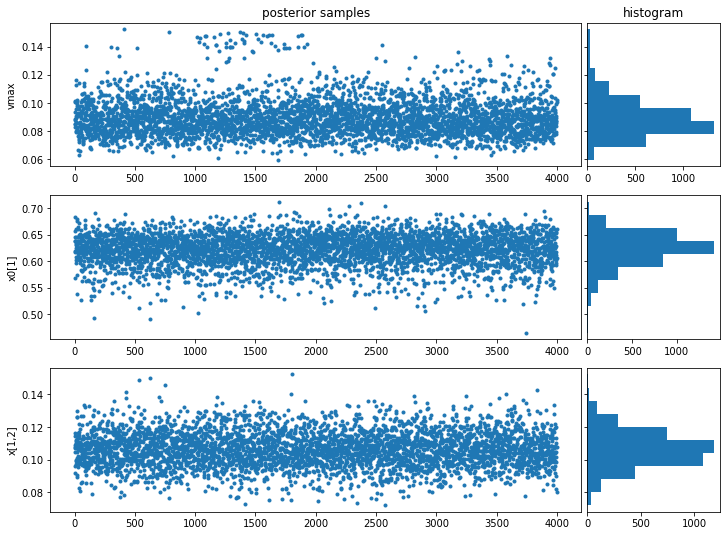

In [19]:
names = ('vmax','x0[1]','x[1,2]')

fig, axs = plt.subplots(nrows=len(names), ncols=2, sharey='row', squeeze=False, 
                        gridspec_kw={'width_ratios':(4,1), 'wspace':0.02}, figsize=(12,3*len(names)))

for axrow,name in zip(axs,names):
    axrow[0].plot(mcmc[name], linestyle='none', marker='.')
    axrow[0].set(ylabel=name)
    axrow[1].hist(mcmc[name], orientation='horizontal')
axs[0,0].set_title('posterior samples')
axs[0,1].set_title('histogram')
None

plotting the distributions

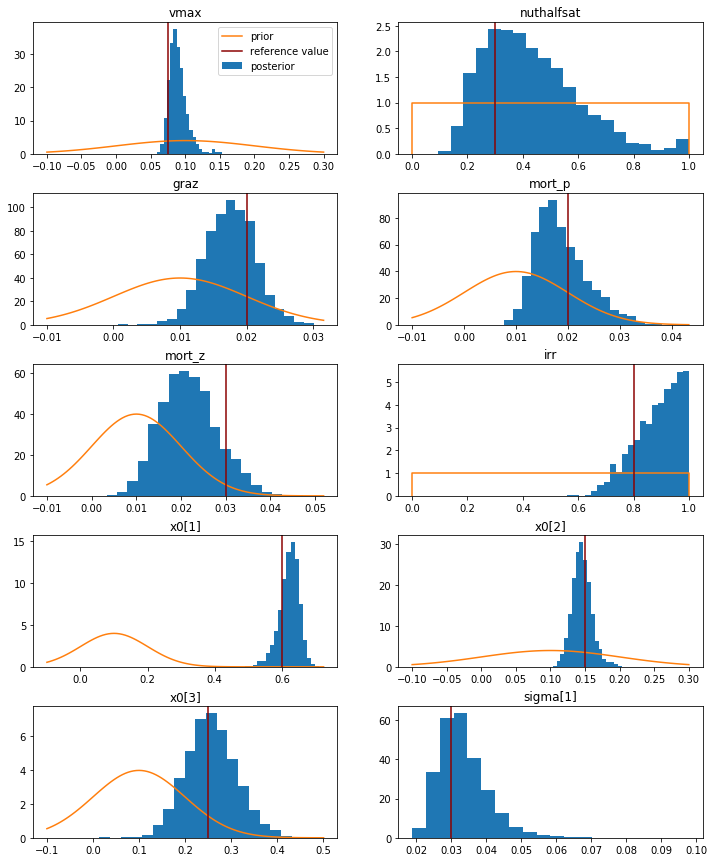

In [10]:
# plotinfo contains information about the prior distribution and the reference value of 
# the parameters and initial conditions used for plotting. If these are changed in the 
# code above, change them here as well. 
plotinfo = {
    'vmax':{'priordist':'normal', 'priorparams':(0.1,0.1), 'refvalue':0.075},
    'nuthalfsat':{'priordist':'uniform', 'priorparams':(0.0,1.0), 'refvalue':0.3},
    'graz':{'priordist':'normal', 'priorparams':(0.01,0.01), 'refvalue':0.02},
    'mort_p':{'priordist':'normal', 'priorparams':(0.01,0.01), 'refvalue':0.02},
    'mort_z':{'priordist':'normal', 'priorparams':(0.01,0.01), 'refvalue':0.03},
    'irr':{'priordist':'uniform', 'priorparams':(0.0,1.0), 'refvalue':0.8},
    'x0[1]':{'priordist':'normal', 'priorparams':(0.1,0.1), 'refvalue':0.6},
    'x0[2]':{'priordist':'normal', 'priorparams':(0.1,0.1), 'refvalue':0.15},
    'x0[3]':{'priordist':'normal', 'priorparams':(0.1,0.1), 'refvalue':0.25},
    'sigma[1]':{'refvalue':0.03},
}

import scipy.stats as stats

ncols = 2
nrows = int(np.ceil(len(plotinfo)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3*nrows), gridspec_kw={'hspace':0.3})
for ax,name in zip(axs.flat, plotinfo):
    ax.hist(mcmc[name], bins=20, density=True, label='posterior')
    xlim = ax.get_xlim()
    if 'priordist' in plotinfo[name]:
        if plotinfo[name]['priordist'] == 'normal':
            p = plotinfo[name]['priorparams']
            x_min = min(p[0]-2*p[1], xlim[0])
            x_max = max(p[0]+2*p[1], xlim[1])
            x = np.linspace(x_min, x_max, 100)
            ax.plot(x, stats.norm.pdf(x, loc=p[0], scale=p[1]), label='prior')
        elif plotinfo[name]['priordist'] == 'uniform':
            p = plotinfo[name]['priorparams']
            y = 1.0/(p[1]-p[0])
            ax.plot([p[0],p[0],p[1],p[1]], [0,y,y,0], label='prior')
    ax.axvline(plotinfo[name]['refvalue'], color='darkred', label='reference value')
    ax.set(title=name)
axs.flat[0].legend()
None

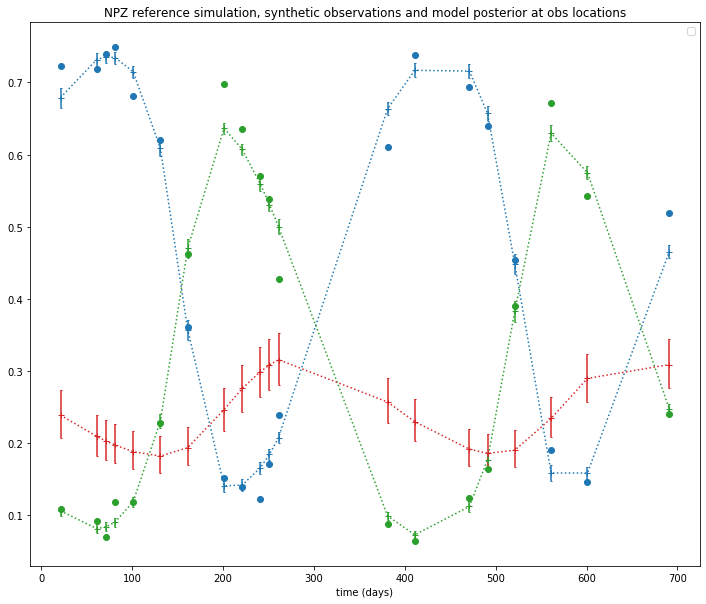

In [11]:
# plot results

colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

x_quant = np.percentile(mcmc['x'], (25,50,75), axis=0)

fig,ax = plt.subplots(figsize=(12,10))

for i,name in enumerate(('N','P','Z')):
    #ax.plot(t,x[:,i], color=colors[i], label=name)
    ax.errorbar(x=tobs, y=x_quant[1,:,i], yerr=np.array((x_quant[1,:,i]-x_quant[0,:,i],x_quant[2,:,i]-x_quant[1,:,i])), ls=':', color=colors[i], marker='+', capsize=1.0)
for i, ivar in enumerate(iobsvar):
    ax.plot(tobs, obs[:,i], color=colors[ivar], marker='o', ls='none')
ax.set(title='NPZ reference simulation, synthetic observations and model posterior at obs locations', xlabel='time (days)')
ax.legend()
None

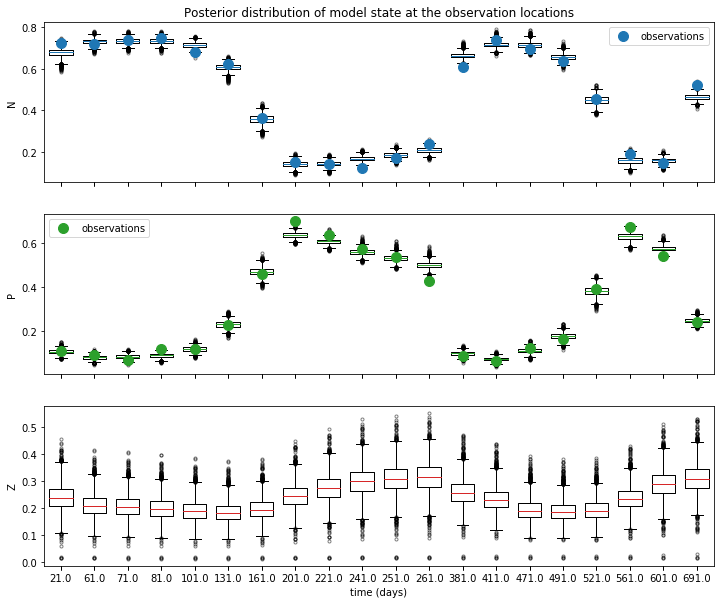

In [12]:
positions = range(len(tobs))

fig,axs = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
for ivar,ax in enumerate(axs.flat):
    ax.boxplot(mcmc['x'][:,:,ivar], positions=positions, medianprops={'color':colors[ivar]}, flierprops={'marker':'.', 'alpha':0.5}, widths=0.7)
    ax.set(ylabel='NPZ'[ivar])
for i,ivar in enumerate(iobsvar):
    axs[ivar].plot(positions, obs[:,i], marker='o', markersize=10, ls='none', label='observations', color=colors[ivar])
    axs[ivar].legend()
axs[0].set(title='Posterior distribution of model state at the observation locations')
axs[-1].set(xticklabels=tobs, xlabel='time (days)')
None

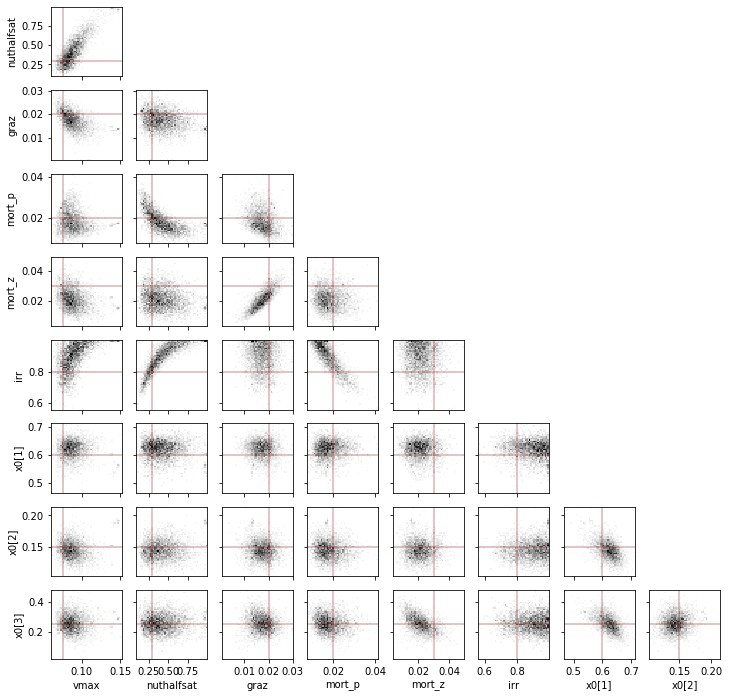

In [13]:
parameter_names = ['vmax','nuthalfsat','graz','mort_p','mort_z','irr','x0[1]','x0[2]','x0[3]']
nparam = len(parameter_names)
cmap = plt.get_cmap('gray_r')

fig,axs = plt.subplots(nrows=nparam-1, ncols=nparam-1, sharex='col', sharey='row', figsize=(12,12))
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,nparam):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = parameter_names[icol]
        yname = parameter_names[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=cmap)
        ax.axvline(plotinfo[xname]['refvalue'], color='darkred', alpha=0.3)
        ax.axhline(plotinfo[yname]['refvalue'], color='darkred', alpha=0.3)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == nparam-1:
            ax.set_xlabel(xname)